### Manhatten Plot for example cluster

including:
* for each egene and cluster pc:
    * nominal ps
    * lead variant for each independent signal via susie 
    * credible set via susie
* gene annotations
    * genes in cluster
        * variance in gene expression explained by each pc
    * genes not in cluster?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from scipy.stats import linregress


import seaborn as sns 
from tqdm.auto import tqdm  # for notebooks
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
from matplotlib.lines import Line2D



## Load in the data
* nominal p values for control eqtl and cluster
* susie for control eqtl and susie
* gene annotations

In [3]:

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']
pc_output_dir = config['pc_output_dir']
filtered_expression_output_dir = config['filtered_expression_output_dir']


# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

# select just 1 tissue id to do for now 
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type
tissue_ids = [tissue_id]
chr_id = 11


In [70]:
# load nominal p value dfs

def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['variant_pos'] = var_pos(e_nominal_df)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_df = load_e_nominal(f'{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet')


def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['variant_pos'] = var_pos(pc_nominal_df)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    pc_nominal_df['cluster_size'] = pc_nominal_df['phenotype_id'].str.split('_').str.len() - 1
    pc_nominal_df['pc_id'] = pc_nominal_df['phenotype_id'].str.split('_pc').str[-1].astype(int)
    return pc_nominal_df

pc_nominal_df = load_pc_nominal(f'{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl_pairs.chr{chr_id}.parquet')
pc_nominal_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,variant_pos,cluster_id,cluster_size,pc_id
0,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_123066_C_A_b38,-184565,-198274,0.016563,14,16,0.141729,-0.020407,0.013861,123066,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,3,1
1,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_128951_G_C_b38,-178680,-192389,0.058352,51,51,0.802063,-0.002027,0.008079,128951,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,3,1
2,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_132548_T_C_b38,-175083,-188792,0.045549,44,44,0.726181,-0.003127,0.008922,132548,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,3,1
3,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_133366_A_G_b38,-174265,-187974,0.207039,159,200,0.680608,-0.001573,0.003818,133366,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,3,1
4,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_133399_C_G_b38,-174232,-187941,0.035197,34,34,0.153837,0.014621,0.010234,133399,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,3,1


In [71]:
# load susie dfs
def get_lead_var(susie_df):
    lv = susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')
    return susie_df['cs_full_id'].map(lv['variant_id'])

def load_e_susie(path):
    e_susie_df = pd.read_csv(path, sep='\t', index_col=0)
    e_susie_df['cluster_id'] = e_susie_df['phenotype_id'].str.split('_e_').str[0]
    e_susie_df['egene_id'] = e_susie_df['phenotype_id'].str.split('_e_').str[1]
    e_susie_df['cs_full_id'] = e_susie_df['phenotype_id'].astype(str) + '_e_cs' + e_susie_df['cs_id'].astype(str) 
    e_susie_df['lead_variant'] = get_lead_var(e_susie_df)
    e_susie_df['is_lead'] = e_susie_df['variant_id'] == e_susie_df['lead_variant']
    e_susie_df['variant_pos'] = var_pos(e_susie_df)
    return e_susie_df

e_susie_df = load_e_susie(f'{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt')
# filter to only the chromosome we're considering
e_susie_df = e_susie_df[e_susie_df['variant_id'].str.split('_').str[0] == f'chr{chr_id}']

def load_pc_susie(path):
    pc_susie_df = pd.read_csv(path, sep='\t', index_col=0)
    pc_susie_df['cluster_id'] = pc_susie_df['phenotype_id'].str.split('_pc').str[0]
    pc_susie_df['cs_full_id'] = pc_susie_df['phenotype_id'].astype(str) + '_cs' + pc_susie_df['cs_id'].astype(str)
    pc_susie_df['lead_variant'] = get_lead_var(pc_susie_df)
    pc_susie_df['is_lead'] = pc_susie_df['variant_id'] == pc_susie_df['lead_variant']
    pc_susie_df['variant_pos'] = var_pos(pc_susie_df)
    pc_susie_df['pc_id'] = pc_susie_df['phenotype_id'].str.split('_pc').str[-1].astype(int)
    return pc_susie_df

pc_susie_df = load_pc_susie(f'{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.susie.txt')
# filter to only the chromosome we're considering
pc_susie_df = pc_susie_df[pc_susie_df['variant_id'].str.split('_').str[0] == f'chr{chr_id}']

pc_susie_df.head()

,phenotype_id,variant_id,pip,af,cs_id,cluster_id,cs_full_id,lead_variant,is_lead,variant_pos,pc_id
4062,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_354756_C_G_b38,0.494161,0.360248,1,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_354756_C_G_b38,True,354756,1
4063,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_355039_CTAA_C_b38,0.096390,0.358178,1,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_354756_C_G_b38,False,355039,1
4064,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_356080_T_C_b38,0.409449,0.364389,1,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_354756_C_G_b38,False,356080,1
4065,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_308065_T_C_b38,1.000000,0.939959,2,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_308065_T_C_b38,True,308065,1
4066,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_306877_C_T_b38,0.810066,0.083851,3,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,chr11_306877_C_T_b38,True,306877,1


In [6]:
# load in pc data
pc_df = pd.read_csv(f'{prefix}/{pc_output_dir}/{tissue_id}.pcs.bed', sep='\t')
# get a list of all the sample ids
sample_ids = pc_df.columns[4:]
# add a cluster id and pc number column
pc_df['cluster_id'] = pc_df['gene_id'].str.split('_pc').str[0]
pc_df['pc_id'] = pc_df['gene_id'].str.split('_pc').str[1].astype('float')
pc_df['cluster_size'] = pc_df['cluster_id'].str.split('_').apply(len)
# filter to only the chromosome we're considering
pc_df = pc_df[pc_df['#chr'] == f'chr{chr_id}']

pc_df.head()

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,pc_id,cluster_size
306,chr11,307630,321340,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,-0.005235,0.117407,0.066417,0.028389,-0.005685,-0.050030,...,-0.003626,0.046199,0.020811,0.017039,0.089781,0.081930,0.000005,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,1.0,3
307,chr11,307630,321340,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,0.003198,-0.029901,0.030284,-0.012198,-0.037627,-0.022717,...,0.004812,0.063697,0.001693,-0.057826,-0.011684,0.058966,0.007279,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,2.0,3
308,chr11,307630,321340,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,-0.008063,0.051415,0.020291,0.037287,0.029239,0.023162,...,0.013110,0.014580,0.000116,-0.016139,0.079394,-0.008577,0.084593,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,3.0,3
309,chr11,392613,417397,ENSG00000184363.9_ENSG00000185187.12_pc1,-0.005810,-0.012604,-0.063050,0.059208,0.044086,-0.006412,...,-0.010722,-0.065137,-0.025888,-0.006501,-0.080857,0.036923,0.029080,ENSG00000184363.9_ENSG00000185187.12,1.0,2
310,chr11,392613,417397,ENSG00000184363.9_ENSG00000185187.12_pc2,-0.059537,-0.010817,0.014959,0.072374,-0.001149,0.027076,...,0.042842,0.079547,-0.007076,-0.056002,-0.001519,0.012776,0.016975,ENSG00000184363.9_ENSG00000185187.12,2.0,2


In [7]:
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{filtered_expression_output_dir}/{tissue_id}.v8.normalized_expression.cluster_genes.bed', sep='\t')
# add a cluster id and pc number column
expression_df['cluster_id'] = expression_df['gene_id'].str.split('_e_').str[0]
expression_df['egene_id'] = expression_df['gene_id'].str.split('_e_').str[1]
# filter to only the chromosome we're considering
expression_df = expression_df[expression_df['#chr'] == f'chr{chr_id}']


expression_df.head()

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,egene_id
302,chr11,307630,321340,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,-0.003323,0.091121,0.027858,0.017129,0.007641,-0.032924,...,0.004707,-0.009534,-0.004618,0.015021,0.050447,0.051034,0.032664,-0.030222,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000185201.16
303,chr11,307630,321340,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,-0.008789,0.127198,0.066450,0.044128,0.011469,-0.029503,...,0.021671,0.003863,0.045744,0.017617,0.006755,0.118502,0.063635,0.045103,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000185885.15
304,chr11,307630,321340,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,0.000141,0.057573,0.062583,0.004043,-0.034500,-0.057882,...,0.008677,-0.003636,0.068281,0.016812,-0.016232,0.039298,0.099247,-0.019501,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,ENSG00000142089.15
305,chr11,392613,417397,ENSG00000184363.9_ENSG00000185187.12_e_ENSG000...,-0.031788,0.003366,0.059047,-0.002632,-0.035597,0.021623,...,0.025926,0.034670,0.100172,0.016166,-0.029080,0.063071,-0.021417,-0.012643,ENSG00000184363.9_ENSG00000185187.12,ENSG00000184363.9
306,chr11,392613,417397,ENSG00000184363.9_ENSG00000185187.12_e_ENSG000...,0.040986,0.016587,0.040762,-0.091096,-0.034192,-0.011472,...,-0.059523,-0.017697,0.002940,0.024815,0.039372,0.064928,-0.037033,-0.033392,ENSG00000184363.9_ENSG00000185187.12,ENSG00000185187.12


In [8]:
# load gene annotations
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

# filter to just the genes in clusters on the chromosome we're considering
gene_ids = expression_df['egene_id'].unique()
gid_gencode = full_gencode.set_index('transcript_id').loc[gene_ids]
gid_gencode = gid_gencode.drop_duplicates()
gid_gencode['tss_start'] = np.where(gid_gencode['strand'] == '+', gid_gencode['start'], gid_gencode['end'])
gid_gencode['gene_end'] = np.where(gid_gencode['strand'] == '-', gid_gencode['start'], gid_gencode['end'])

### variance per pc

In [9]:
# for each cluster, for each pc, pull the largest two values

# the expression and pc values for this cluster
for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
    expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
    gene_variances = []
    for i in range(len(expression_cluster)):
        # pull the right data
        pc_values = row[sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        gene_variances.append((r_value**2)*100)
    gene_variances.sort()
    pc_df.loc[idx, 'largest_variance'] = gene_variances[-1]
    pc_df.loc[idx, 'second_largest_variance'] = gene_variances[-2]
    pc_df.loc[idx, 'total_variance'] = sum(gene_variances)

    

  0%|          | 0/2287 [00:00<?, ?it/s]

In [40]:
# pull an example cluster
cluster_id = expression_df['cluster_id'].iloc[1987]
 
expression_cluster = expression_df[expression_df['cluster_id'] == cluster_id].reset_index()
pc_cluster = pc_df[pc_df['cluster_id'] == cluster_id].reset_index()

# pull gene locations 
cluster_gencode = gid_gencode.loc[expression_cluster['egene_id']]

In [41]:
# the expression and pc values for this cluster
expression_cluster = expression_df[expression_df['cluster_id'] == cluster_id].reset_index()
pc_cluster = pc_df[pc_df['cluster_id'] == cluster_id].reset_index()

rs = np.zeros((len(expression_cluster), len(pc_cluster)))

for i in range(len(expression_cluster)):
    for j in range(len(pc_cluster)):
        # pull the right data
        pc_values = pc_cluster.loc[j, sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        rs[i,j] = (r_value**2)*100

rs_df = pd.DataFrame(rs, columns=[f'pc{i+1}' for i in range(len(pc_cluster))], index=expression_cluster['egene_id'])
# match rs to same order as gencode
rs_df = rs_df.loc[cluster_gencode.index]
rs_df.reset_index()

# add the location for the variance to be ploted as the gene tss
rs_df['position'] = cluster_gencode['tss_start']

# split out all the pc values into one column
rs_melt_df = rs_df.reset_index().melt(id_vars=['position', 'transcript_id'], value_vars=rs_df.columns[:-1].values, 
                  var_name='pc_num')


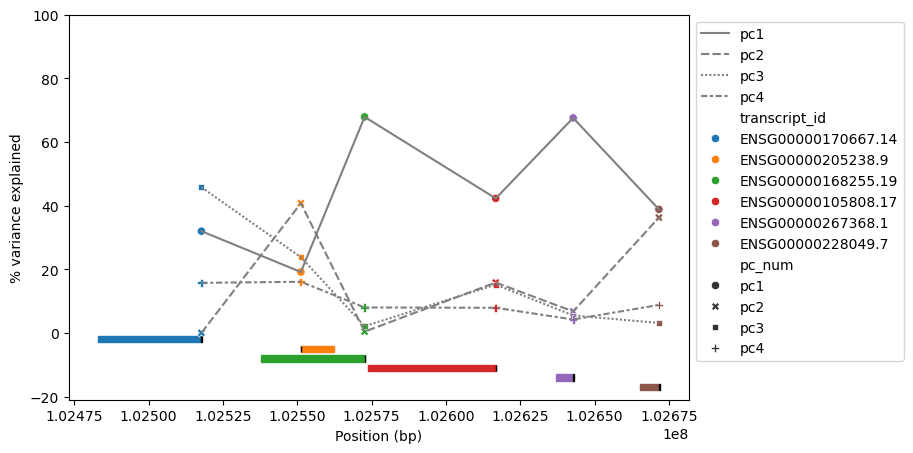

In [42]:
# plot 
add_text=False
max_num_pcs = 4


fig, ax = plt.subplots(figsize=(8,5))
# set axis limits 
ax.set_ylim(-(len(cluster_gencode)+1)*3,100)
x_padding = 10000
ax.set_xlim(cluster_gencode['start'].min() - x_padding, cluster_gencode['end'].max() + x_padding)


# add a rectangle for each gene location
for i in range(len(cluster_gencode)):
    row = cluster_gencode.iloc[i]
    # rectangle patch for gene body
    rect = patches.Rectangle((row['start'], -3-i*3), row['end']-row['start'], 2, linewidth=1, edgecolor=sns.color_palette()[i%10], facecolor=sns.color_palette()[i%10])
    ax.add_patch(rect)
    # black line for tss location
    rect = patches.Rectangle((row['tss_start'], -3-i*3), 200, 2, linewidth=1, edgecolor='k', facecolor='k')
    ax.add_patch(rect)

plot_rs_melt_df = rs_melt_df[rs_melt_df['pc_num'].isin([f'pc{i+1}' for i in range(max_num_pcs)])]

# plot the varaince explained as a scatterplot
sns.lineplot(plot_rs_melt_df, y='value', x='position', style='pc_num', color='grey')
sns.scatterplot(plot_rs_melt_df, y='value', x='position', hue='transcript_id', style='pc_num', ax=ax)

if add_text:
    # add text to the scatterplot
    for i in range(plot_rs_melt_df.shape[0]):
        ax.text(plot_rs_melt_df['position'].iloc[i]+100, plot_rs_melt_df['value'].iloc[i]+1, 
            '{:.2f}%'.format(plot_rs_melt_df['value'].iloc[i]), horizontalalignment='left', size='medium', color='k')

# Add the patch to the Axes
ax.set_xlabel('Position (bp)')
ax.set_ylabel('% variance explained')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

## Manhatten plot

In [13]:
def plot_manhatten_cs(cluster_id):
    gene_ids = cluster_id.split('_')

    f, ax = plt.subplots(figsize=(10, 7))

    # plotting for the eqtls
    for i in range(len(gene_ids)):
        gene_id = gene_ids[i]
        nominal_set = e_nominal_df[e_nominal_df['egene_id'] == gene_id]
        num_cs = len(e_susie_df[e_susie_df['egene_id'] == gene_id]['cs_id'].unique())
        susie_set=e_susie_df[e_susie_df['egene_id'] == gene_id]
        
        # nominal p values
        sns.scatterplot(nominal_set,
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'eqtl {gene_id} nominal p ({num_cs} signifigant)',
                        color=sns.color_palette()[i+2], 
                        s=10, 
                        linewidth=0)
        # susie credible sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie credible set',
                        color=sns.color_palette()[i+2], 
                        marker='*', 
                        s=100, 
                        linewidth=0)
        # susie lead vars sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set[susie_set['is_lead']]['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie lead variant',
                        color=sns.color_palette()[i+2], 
                        marker='X', 
                        s=300, 
                        linewidth=0)

    # plotting for the pcqtls
    for i in range(2):

        nominal_set = pc_nominal_df[pc_nominal_df['cluster_id'] == cluster_id]
        num_cs = len(pc_susie_df[pc_susie_df['cluster_id'] == cluster_id]['cs_id'].unique())
        susie_set=pc_susie_df[pc_susie_df['cluster_id'] == cluster_id]

        # nominal p values
        sns.scatterplot(nominal_set,
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'pc{i+1}qtl nominal p ({num_cs} signifigant)',
                        color=sns.color_palette()[i], 
                        s=10, 
                        linewidth=0)
        # susie credible sets

        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie credible set',
                        color=sns.color_palette()[i], 
                        marker='*', 
                        s=100, 
                        linewidth=0)
        # susie lead vars sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set[susie_set['is_lead']]['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie lead variant',
                        color=sns.color_palette()[i], 
                        marker='X', 
                        s=300, 
                        linewidth=0)
        

    gene_df = gid_gencode.loc[gene_ids]

    ax.set(yscale='log')
    ax.invert_yaxis()

    box_width =-.03*np.log10(ax.get_ylim()[1])
    box_init=box_width
    for i in range(len(gene_df)):
        row = gene_df.iloc[i]
        ystart = 10**(box_init + 2*box_width*i)
        yend = 10**(box_init + 2*box_width*i + box_width)

        rect = patches.Rectangle((row.start,ystart), 
                                row.end-row.start, yend-ystart, 
                                facecolor=sns.color_palette()[i+2], 
                                edgecolor =sns.color_palette()[i+2]) 
        ax.add_patch(rect)

        if row.strand=='+':
            tss_start = row.start
        else:
            tss_start=row.end
        rect = patches.Rectangle((tss_start,ystart), 
                                100, yend-ystart, 
                                facecolor='none', 
                                edgecolor ='k') 
        ax.add_patch(rect)

    ax.set_ylim(10**(box_init + 2*box_width*(i+1)), ax.get_ylim()[1])
    # get labels to we can keep them the same even after adding room for the genes
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[yticks<=1])

    ax.legend()
    return ax

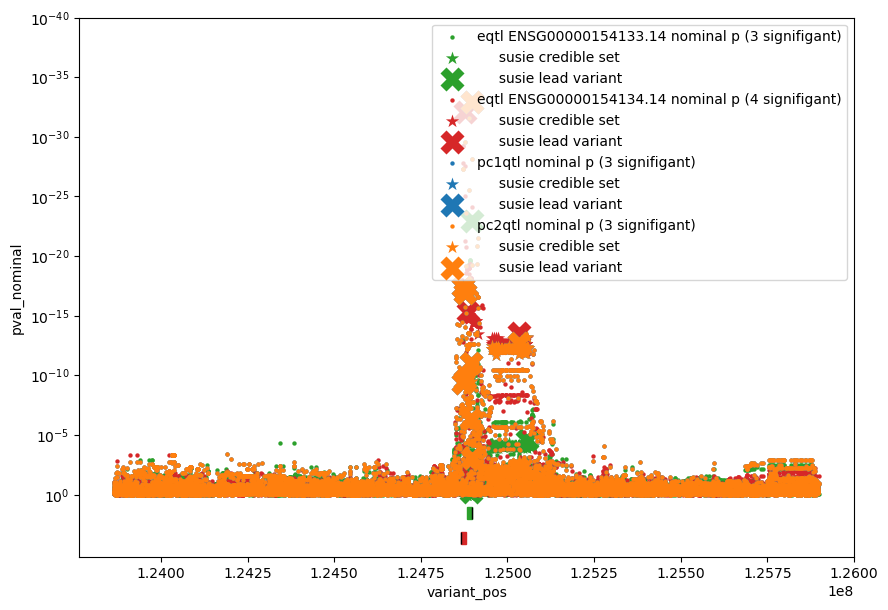

In [14]:
ax = plot_manhatten_cs(cluster_id)
plt.show()

## split out types of plots

In [94]:
def plot_genes(cluster_id, ax, scalebar=True, x_padding = 500000, palette = sns.color_palette()):
    gene_ids = cluster_id.split('_')
    cluster_gencode = gid_gencode.loc[gene_ids]

    # Sort the dataframe by 'start'
    cluster_gencode = cluster_gencode.sort_values('start')

    # this list will store the end of the last gene at each level:
    ends_of_genes = [0]
    # row height:
    height = .3

    # for each gene
    for i in range(len(cluster_gencode)):
        gene = cluster_gencode.iloc[i]
        # for each level
        for level, end in enumerate(ends_of_genes):
            # if this gene does not overlap with the last gene at this level
            if gene['start'] > end:
                # place the gene at this level
                arrow = patches.FancyArrow(x = gene['tss_start'], y=height*level, dx=(gene['gene_end'] - gene['tss_start']), 
                                           dy=0, width=.1, head_length = 10000, edgecolor=palette[i%10], 
                                           facecolor=palette[i%10])

                ax.add_patch(arrow)
                # update the end of the last gene at this level
                ends_of_genes[level] = gene['end']
                break
        else:
            # all levels are occupied, we need to create a new level:
            ends_of_genes.append(gene['gene_end'])
            arrow = patches.FancyArrow(x = gene['tss_start'], y=height*(len(ends_of_genes) - 1), dx=(gene['gene_end'] - gene['tss_start']), 
                                           dy=0, width=.1, head_length = 10000, edgecolor=palette[i%10], 
                                           facecolor=palette[i%10])

            ax.add_patch(arrow)
    
    # Set plot limits
    ax.set_ylim(-1*height, height*len(ends_of_genes))
    # padding for the cis window
    ax.set_xlim(cluster_gencode['start'].min() - x_padding, cluster_gencode['end'].max() + x_padding)

    # to remove black outlines for gene plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # remove y axis and ticks
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

    # remove x axis and ticks
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])

    return ax


def plot_scalebar(ax, scalebar_length = 200000, side='left'):
    # add in scalebar
    scalebar_label=f'{scalebar_length/1000:.0f} kb'

    if side=='left':
        # Adding scale bar
        scalebar_start = ax.get_xlim()[0]+10000
        scalebar = mlines.Line2D([scalebar_start, scalebar_start + scalebar_length], [np.mean(ax.get_ylim()),np.mean(ax.get_ylim())], color='k')
    elif side=='right':
        scalebar_start = ax.get_xlim()[1]-10000 - scalebar_length
        scalebar = mlines.Line2D([scalebar_start, scalebar_start + scalebar_length], [np.mean(ax.get_ylim()),np.mean(ax.get_ylim())], color='k')

    ax.add_line(scalebar)

    # Adding caps for bar
    cap_length = (ax.get_ylim()[1] - ax.get_ylim()[0])/5
    cap1 = mlines.Line2D([scalebar_start, scalebar_start], [np.mean(ax.get_ylim()) - cap_length / 2., np.mean(ax.get_ylim()) + cap_length / 2.], color='k')
    cap2 = mlines.Line2D([scalebar_start + scalebar_length, scalebar_start + scalebar_length], [np.mean(ax.get_ylim()) - cap_length / 2., np.mean(ax.get_ylim()) + cap_length / 2.], color='k')
    ax.add_line(cap1)
    ax.add_line(cap2)

    # Adding text
    ax.text(scalebar_start + scalebar_length / 2, np.mean(ax.get_ylim()) + cap_length, scalebar_label, ha='center')  
    return ax

In [95]:
def plot_cs(nominal_set, susie_set, gene_color, ax, use_color_cs=True):
        # nominal p values
        sns.scatterplot(nominal_set,
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        color=gene_color, 
                        s=10, 
                        linewidth=0)
        # susie credible sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        color=gene_color if use_color_cs else 'black', 
                        marker='*', 
                        s=100, 
                        linewidth=.1)
        # susie lead vars sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set[susie_set['is_lead']]['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        color=gene_color if use_color_cs else 'red', 
                        marker='x', 
                        s=100, 
                        linewidth=3)
        
        # to remove black outlines for gene plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # set y label
        ax.set_ylabel('nominal p-value')

        
        return ax

In [104]:
        
def add_legend(gene_ids, ax, palette=sns.color_palette()):
    # create handles for 'gene' section of legend
    handles_colors_genes = [patches.Patch(color=palette[i], label=gene) for i, gene in enumerate(gene_ids)]
    # create handels for 'pcs' section of legend
    handles_colors_pcs = [patches.Patch(color=palette[i+len(gene_ids)+1], label=f'pc {i+1}') for i in range(len(gene_ids))]
    # create custom handles for 'marks' section of legend
    handles_marks = [Line2D([0], [0], color='black', marker='.', markersize=4, linestyle='None', label='nominal p-value'),
                    Line2D([0], [0], color='black', marker='*', markersize=7, linestyle='None', label='credible set'),
                    Line2D([0], [0], color='red', marker='x', markersize=7, linestyle='None', label='lead variant')]

    # add in section titles
    handles = [Line2D([], [], color='none', label='Genes'), *handles_colors_genes, 
               Line2D([], [], color='none', label='PCs'), *handles_colors_pcs,
               Line2D([], [], color='none', label='Markers'), *handles_marks]

    ax.legend(handles=handles, loc='center left', frameon=False)

    # to remove black outlines for gene plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # remove y axis and ticks
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

    # remove x axis and ticks
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])


In [105]:
expression_df[expression_df['cluster_id'].str.split('_').apply(len) > 3]


,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,egene_id
369,chr11,73983306,74171211,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,0.062148,0.021567,0.040438,0.044167,-0.101566,0.027529,...,0.050115,0.011102,0.057718,-0.030235,0.020032,0.094524,-0.006600,0.006299,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,ENSG00000175567.8
370,chr11,73983306,74171211,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,-0.028915,0.065580,-0.019659,-0.006889,0.000553,0.033342,...,0.010594,0.081371,-0.098627,0.016295,0.038975,0.007111,-0.015541,-0.015003,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,ENSG00000175564.12
371,chr11,73983306,74171211,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,0.046852,0.015581,0.004890,-0.021135,-0.080080,-0.026218,...,0.008332,0.113433,-0.092113,-0.056937,-0.001830,-0.001984,-0.042658,0.075770,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,ENSG00000168014.16
372,chr11,73983306,74171211,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,0.071641,0.014326,0.017786,-0.043619,-0.054134,-0.003207,...,0.035433,0.074722,-0.076843,-0.030487,0.015022,-0.008077,-0.071854,0.037649,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,ENSG00000214517.9


In [106]:
sns.diverging_palette(220, 20, n=num_genes*2+1)

[(0.24715576253545807, 0.49918708160096675, 0.5765599057376697),
 (0.42054333728346904, 0.6115806579747427, 0.6706176282584673),
 (0.5966295101492012, 0.7257235240198634, 0.7661392618658618),
 (0.7700170848972121, 0.8381171003936393, 0.8601969843866594),
 (0.9500463204266012, 0.9458771880685795, 0.945349903258932),
 (0.9038002148101664, 0.7912297658937751, 0.7634130883082537),
 (0.8562281592866621, 0.6365099987803562, 0.5811869985022731),
 (0.8090263254790442, 0.48299431286611855, 0.4003790533382429),
 (0.7634747047461135, 0.3348456555528834, 0.225892295531744)]

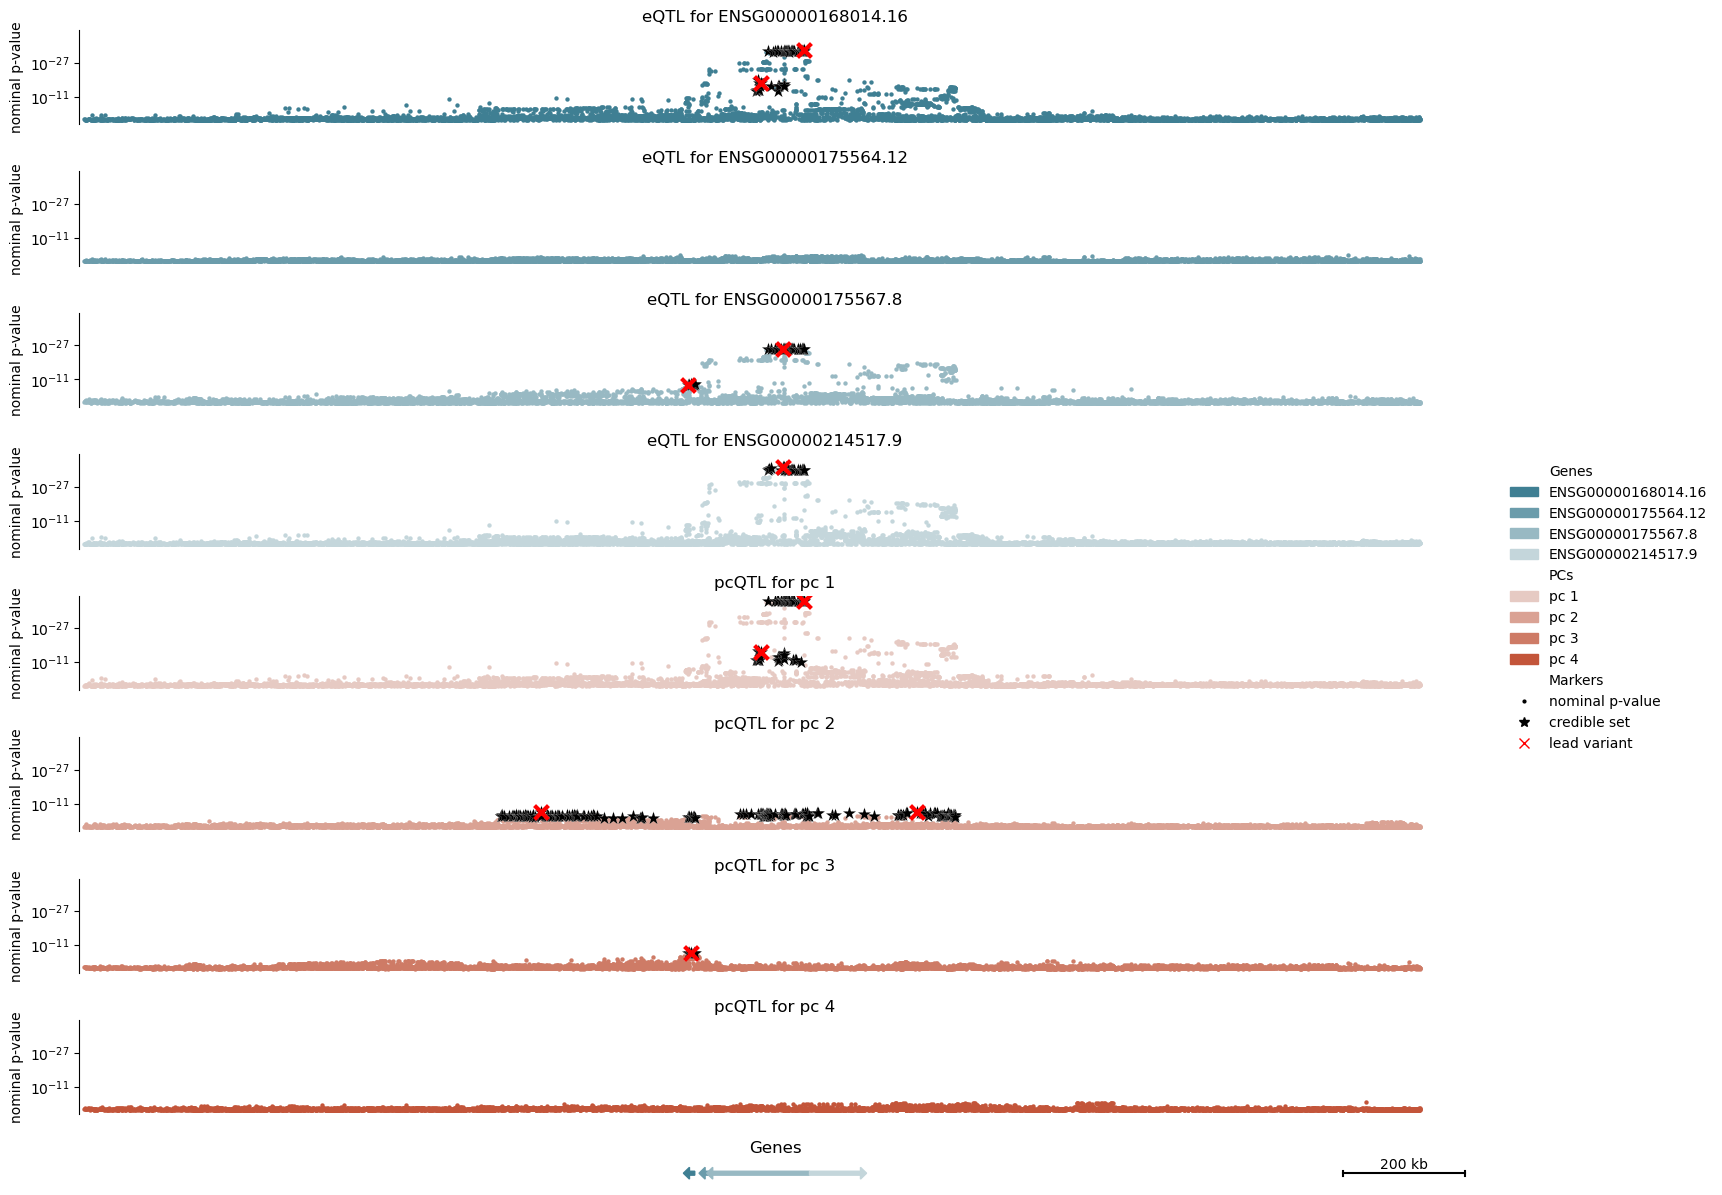

In [107]:
# genes plot 
# pull an example cluster
cluster_id = expression_df['cluster_id'].loc[369]
gene_ids = cluster_id.split('_')

# create a gridspec object

# Create a 2x2 figure with specified figure width
fig = plt.figure(figsize=(20, 15)) 

num_genes = len(gene_ids)
num_manhatten = num_genes*2
# colors (1st half is genes, 2nd half is pcs)
palette = sns.diverging_palette(220, 20, n=num_genes*2+1)

x_padding = 1000000 #1000000 for the full cis-window
# cols determines the width of the legend vs the plots
num_cols=10

# set up axes for the different plots 
gs = gridspec.GridSpec(num_manhatten*2+1, num_cols)

# one plot for each gene's manhatten, plus one for gene arrows on the bottom
# manhatten plots are twice the height as the arrow plot
axes_arrows = plt.subplot(gs[num_manhatten*2, :num_cols-1])
# plot for the legend on the right side
axes_legend = plt.subplot(gs[:, num_cols-1])

# axes for each manhattenplot
for i in range(num_manhatten):
    if i==0:
        axs = [plt.subplot(gs[i*2:i*2 + 2, :num_cols-1], sharex=axes_arrows)]
        # log scale y axis
        axs[0].set(yscale='log')
        axs[0].invert_yaxis()
    else:
        axs.append(plt.subplot(gs[i*2:i*2 + 2, :num_cols-1], sharex=axes_arrows, sharey=axs[0]))


# add in the gene arrows
plot_genes(cluster_id, axes_arrows, x_padding=x_padding, palette = palette)
axes_arrows.set_title('Genes')

# add in a scalebar
plot_scalebar(axes_arrows, scalebar_length = x_padding/5, side='right')

# add in manhattenplots for each e gene
for i in range(num_genes):
    nominal_set = e_nominal_df[e_nominal_df['egene_id'] == gene_ids[i]]
    susie_set=e_susie_df[e_susie_df['egene_id'] == gene_ids[i]]
    plot_cs(nominal_set, susie_set, palette[i], axs[i], use_color_cs=False)
    axs[i].set_title(f'eQTL for {gene_ids[i]}')


# add in manhattenplots for each pc
for i in range(num_genes):
    nominal_set = pc_nominal_df[(pc_nominal_df['cluster_id'] == cluster_id)&((pc_nominal_df['pc_id'] == i+1))]
    susie_set=pc_susie_df[(pc_susie_df['cluster_id'] == cluster_id)&(pc_susie_df['pc_id']==i+1)]
    plot_cs(nominal_set, susie_set, palette[num_genes+i+1], axs[i+num_genes], use_color_cs=False)
    axs[i+num_genes].set_title(f'pcQTL for pc {i+1}')


# add in a legend
add_legend(gene_ids, axes_legend, palette=palette)

# add some spacing
plt.subplots_adjust(hspace=2)
plt.show()

In [68]:
cluster_id

'ENSG00000168014.16_ENSG00000175564.12_ENSG00000175567.8_ENSG00000214517.9'

In [74]:
pc_nominal_df[(pc_nominal_df['cluster_id'] == cluster_id)&((pc_nominal_df['pc_id'] == i))]

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,variant_pos,cluster_id,cluster_size,pc_id
502757,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_72983581_A_G_b38,-999726,-1187630,0.012422,12,12,0.189439,-0.019799,0.015063,72983581,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
502758,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_72985571_G_C_b38,-997736,-1185640,0.016563,16,16,0.182104,0.017918,0.013406,72985571,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
502759,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_72985604_C_T_b38,-997703,-1185607,0.028986,27,28,0.164909,-0.015321,0.011013,72985604,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
502760,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_72986271_G_A_b38,-997036,-1184940,0.296066,239,286,0.675417,-0.001578,0.003766,72986271,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
502761,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_72986625_C_T_b38,-996682,-1184586,0.012422,12,12,0.116403,-0.024673,0.015682,72986625,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509706,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_75169811_C_A_b38,1186504,998600,0.218426,184,211,0.824841,0.000916,0.004134,75169811,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
509707,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_75170211_T_C_b38,1186904,999000,0.208075,176,201,0.953899,-0.000240,0.004149,75170211,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
509708,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_75170600_G_A_b38,1187293,999389,0.745342,213,246,0.556327,0.002379,0.004041,75170600,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3
509709,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,chr11_75170637_C_T_b38,1187330,999426,0.744306,214,247,0.633524,0.001940,0.004067,75170637,ENSG00000168014.16_ENSG00000175564.12_ENSG0000...,4,3


In [ ]:
# plot 
add_text=False
max_num_pcs = 4


fig, ax = plt.subplots(figsize=(8,5))
# set axis limits 
ax.set_ylim(-(len(cluster_gencode)+1)*3,100)
x_padding = 10000
ax.set_xlim(cluster_gencode['start'].min() - x_padding, cluster_gencode['end'].max() + x_padding)


# add a rectangle for each gene location
for i in range(len(cluster_gencode)):
    row = cluster_gencode.iloc[i]
    # rectangle patch for gene body
    rect = patches.Rectangle((row['start'], -3-i*3), row['end']-row['start'], 2, linewidth=1, edgecolor=sns.color_palette()[i%10], facecolor=sns.color_palette()[i%10])
    ax.add_patch(rect)
    # black line for tss location
    rect = patches.Rectangle((row['tss_start'], -3-i*3), 200, 2, linewidth=1, edgecolor='k', facecolor='k')
    ax.add_patch(rect)

plot_rs_melt_df = rs_melt_df[rs_melt_df['pc_num'].isin([f'pc{i+1}' for i in range(max_num_pcs)])]

# plot the varaince explained as a scatterplot
sns.lineplot(plot_rs_melt_df, y='value', x='position', style='pc_num', color='grey')
sns.scatterplot(plot_rs_melt_df, y='value', x='position', hue='transcript_id', style='pc_num', ax=ax)

if add_text:
    # add text to the scatterplot
    for i in range(plot_rs_melt_df.shape[0]):
        ax.text(plot_rs_melt_df['position'].iloc[i]+100, plot_rs_melt_df['value'].iloc[i]+1, 
            '{:.2f}%'.format(plot_rs_melt_df['value'].iloc[i]), horizontalalignment='left', size='medium', color='k')

# Add the patch to the Axes
ax.set_xlabel('Position (bp)')
ax.set_ylabel('% variance explained')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()